In [1]:
import sys
sys.path.append('../')   # If you move this notebook to another location, change this path to point to the root directory of the solutions project
import pandas as pd
from pathlib import Path
from solution import factory
from integrations import integration_base as base
from integrations import elc_integration as elc
pd.set_option('display.float_format', lambda x: f"{x:03.5f}".rstrip('0'))

# Preparation

There are several important manual steps that must take place before the Electricity Generation integration can be completed:
 
 1. If the reference TAM sources need to be updated, that should be done first.
 1. The current grid mix (percentage use of each technology in the integration year) must be set.
 1. For each of the PDS1, PDS2 and PDS3 scenarios, the choice of which corresponding scenario to use for each energy-generating solution must be made.  This will set the adoption of those energy sources within that scenario.
 1. Similarly, for each of the PDS1, PDS2 and PDS3 scenarios, the overall adoption profile for the conventional (+ "large hydro" and "other biomass") energy producing technologies must be set.
 
Note it is generally feasible to start with an approximate value to assess the impact on the results, then refine and try again.

### Initialize the Integration

In [2]:
# This box must be executed every time.
base.integration_clean()   # Uncomment this to remove the results of previous integration attempts
base.integration_start()
elc.setup(2018)             # Define the year we are integrating for

### Reference TAM

If the data sources for the refrence TAM need to be updated, do that directly in the data/elc directory.

### Grid Mix

In [3]:
# elc.load_historical_grid_mix()  retrieves the existing grid mixes.
# and once you have an updated version, you can save it (permanently) with elc.set_as_current_grid_mix(newmix)
# (You don't need to computee the percentages; that will be done automatically.)

elc.load_historical_grid_mix().head()

# elc.grid_mix_for_year(2018)                                  # look at the grid mix for a particular year
# elc.set_as_current_grid_mix( elc.grid_mix_for_year(2018) )   # re-use the previous grid mix

total                                    percent                        
                    2015       2016        2017        2018    2015    2016    2017    2018
coal         10075.05021 10169.4961 10259.45005 10345.49107 0.40619 0.40075 0.39583 0.39338
oil products   946.83753 5779.71825  5881.19618  5985.02963 0.03817 0.22776 0.22691 0.22757
natural gas   5688.98001      2606.      2679.3       2715. 0.22936  0.1027 0.10337 0.10323
nuclear            2571.   929.6524   914.46731   899.08431 0.10365 0.03664 0.03528 0.03419
large hydro        3897.      4049.       4037.   4087.0696 0.15711 0.15956 0.15575 0.15541

### Scenario Choices

In [ ]:
# Customize the choices of scenario as needed.  If you have customizations here, you will need
# to execute this box every time.   (Alternatively, you can put the assignments in integration_base.py
# to make them permanent.)

# example assignment
# base.scenario_names['landfillmethane'] = ['scen_name1','scen_name2','scen_name3']   # etc.

In [4]:
#  Including any alterations you have made above, this is the current set of chosen scenarios

for s in elc.energy_solutions:
    print(f"{s}: {[factory.pds_truename(s,n) for n in base.scenario_names[s]]}")

onshorewind: ['PDS-20p2050-Plausible2020', 'PDS-27p2050-Drawdown2020', 'PDS-27p2050-Optimum2020']
offshorewind: ['PDS-4p2050-Plausible2020.', 'PDS-3p2050-Drawdown2020', 'PDS-6p2050-Optimum2020']
solarpvutil: ['PDS-20p2050-Plausible2020', 'PDS-25p2050-Drawdown2020', 'PDS-25p2050-Optimum2020']
solarpvroof: ['PDS-14p2050-Plausible2020', 'PDS-14p2050-Drawdown2020', 'PDS-14p2050-Optimum2020']
concentratedsolar: ['PDS-4p2050-Plausible (Book Ed. 1)', 'PDS-8p2050-Drawdown (Book Ed.1)', 'PDS-8p2050-Optimum (Book Ed.1)']
geothermal: ['PDS-3p2050-Plausible2020', 'PDS-3p2050-Drawdown2020', 'PDS-6p2050-Optimum2020']
waveandtidal: ['PDS-1p2050-Plausible2020', 'PDS-1p2050-Drawdown2020', 'PDS-2p2050-Optimum2020']
biomass: ['PDS-1p2050-Plausible2020', 'PDS-1p2050-Drawdown2020', 'PDS-1p2050-Optimum2020']
microwind: ['PDS-0p2050-Plausible2020', 'PDS-0p2050-Drawdown2020', 'PDS-0p2050-Optimum2020']
instreamhydro: ['PDS-2p2050-Plausible2020', 'PDS-2p2050-Drawdown2020', 'PDS-2p2050-Optimum2020']
nuclear: ['P

### Conventional Adoption Profile

In [5]:
# This will show you the existing adoption profile.  It is a large complex data structure, so you probably want to
# view it by slices, as shown below

adopt_profile = elc.load_conventional_adoption_profile()

Current conventional adoption profile loaded


<AxesSubplot:>

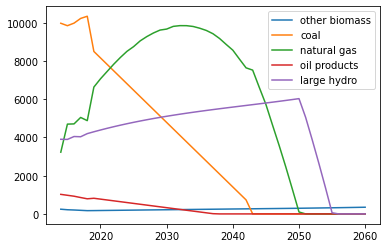

In [6]:

# Some ways to look at the data.   swaplevel is used to move one of the column headers to the top so you can select on it.

# adopt_profile['PDS1']                                    # entire structure for PDS1 only
# adopt_profile.swaplevel(1,0,axis=1)['large hydro']       # look at all three PDS for one technology
# adopt_profile.swaplevel(2,0,axis=1)['percent']           # Look at percents across 

# More on how to work with the adoption profile in the integration steps below.

adopt_profile['PDS1'].swaplevel(axis=1)['total'].plot()


In [13]:
# When you have an adoption profile that you want to work with, you can set it as follows.
#    NOTE/TODO: To make this a permanent change, save the data into the csv file as well.
#    new_profile.to_csv("./data/elc/conventional_adoption_profile.csv")

elc.use_conventional_adoption_profile(new_profile)


Setting conventional adoption profile


# Integration Steps

If you have already set up everything as required, and no further investigation is required, you can run the entire integration simply as follows:
```
elc.integrate()
```

Since you will probably need to do some further investigation to develop the conventional profile, we will walk you through the individual steps

### TAMs

In [7]:
# The first step calculates new integrated TAM.   Warning messages are about NaNs in the data and are not a problem.

elc.step1_calculate_tams()

Previously defined grid mix loaded for year 2018
Reference TAM sources loaded
Loading net energy deltas for all solutions; this takes some time


C:\Working\solutions\integrations\..\model\unitadoption.py:627: RuntimeWarning: invalid value encountered in subtract
  growth_array = np.max([growth.values[1:] - growth.values[:-1], np.full(growth.values[1:].shape, 0.)], axis=0)
C:\ProgramData\Miniconda3\envs\foo\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Miniconda3\envs\foo\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Miniconda3\envs\foo\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Miniconda3\envs\foo\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\P

*** done.
integrated TAM calculated


In [8]:
# At this point, you can look at the TAM

elc.es.reference_tam.head()     # or elc.es.integrated_tam

Year
2014        22548.
2015   24291.85201
2016    24971.0588
2017   25650.26558
2018   26329.47237
Name: World, dtype: float64

<AxesSubplot:xlabel='Year'>

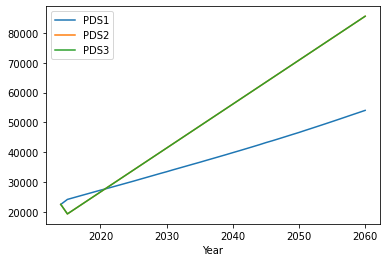

In [9]:
# or plot it

elc.es.integrated_tam.plot()

<AxesSubplot:xlabel='Year'>

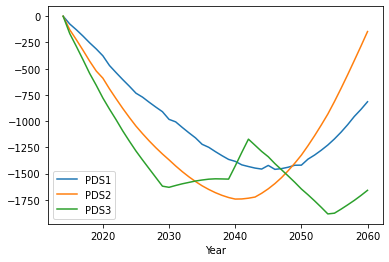

In [10]:
# You can also see the demand delta calculated from all the solutions

base.get_logitem("grid demand delta").plot()

In [11]:
# For convenience, you can also compare the new integrated TAM to the previous values

elc.integrated_tam_comparision().head(10)

PDS1                               PDS2                                PDS3                        
             old         new      delta         old         new       delta         old         new       delta
Year                                                                                                           
2014      22548.      22548.         0.      22548.      22548.          0.      22548.      22548.          0.
2015  24242.3181 24217.74756  -24.57054      24255. 19362.86092 -4892.13908      24255. 19362.86092 -4892.13908
2016 24876.03377 24841.77234  -34.26142      24919.  20834.0963  -4084.9037      24919.  20834.0963  -4084.9037
2017 25778.36189 25461.11192 -317.24997 25848.88526 22305.33169 -3543.55357 25848.88526 22305.33169 -3543.55357
2018 26247.97529 26076.30228 -171.67301 26340.14242 23776.56707 -2563.57535 26340.14242 23776.56707 -2563.57535
2019 26795.58894 26696.75761  -98.83133 25975.92281 25247.80246  -728.12035 25975.92281 25247.80246  -728.12035
2020 27469.60512 27310.73813 -158.86699 26811.37332 26719.03784   -92.33548 26811.37332 26719.03784   -92.33548
2021  28113.8119  27897.2508 -216.56109 27154.51146 28190.27323  1035.76176 27154.51146 28190.27323  1035.76176
2022 28776.61468 28508.53074 -268.08394 27754.96457 29661.50861  1906.54404 27754.96457 29661.50861  1906.54404
2023 29432.91048 29121.58611 -311.32437 28800.57074 31132.74399  2332.17326 28800.57074 31132.74399  2332.17326

### Adoptions

In [12]:
# The second step collects the adoptions of all energy solutions for the chosen scenarios,
# and combines that with the conventional adoption profile.

elc.step2_calculate_adoptions()

using loaded conventional adoption profile
Adoptions calculated


In [13]:
# At this point you can look at the reference or pds adoptions.
# Note that the total TWh numbers are used, and the percentages will be recalculated based on them.

# elc.es.ref_adoption.head(10)
elc.es.pds_adoption.head(10)

PDS1                                                                                                                     ...        PDS3                                                                                                                  
        biogas   biomass        coal concentratedsolar geothermal instreamhydro landfillmethane large hydro microwind natural gas  ... natural gas    nuclear offshorewind oil products onshorewind other biomass solarpvroof solarpvutil wastetoenergy waveandtidal
2014    55.986     62.54  9974.68345                9.    76.0695        547.67           23.99       3904.     1.228  3229.97907  ...       4933.      2417.       24.682   1023.01318     687.046     246.26387         75.      112.63      87.62679       0.9988
2015  72.98223  72.92567  9846.99197           8.60655   77.35677     579.08238           28.57       3897.   1.61843  4697.38358  ...  5688.98001      2571.      9.10433    974.74757   756.25254     211.32706     3.66213    73.66255      91.07977       1.0081
2016  85.07929  83.88122  9980.79247           7.99826   85.14526     602.38664           31.78       4049.   1.92165   4709.0725  ...  5779.71825      2606.      5.54859    926.48195    1093.861     197.42193     124.359   261.34809      94.53275       1.0236
2017  97.21378  95.19111 10226.89221          10.21074    95.5945     624.51117           34.88       4037.   2.23907   5046.8901  ...  5881.19618 2337.17747     14.34359    857.15438  1465.41969      180.7527   262.49078   481.10486      97.98573        1.041
2018  109.4228 106.82962 10341.48673          15.38252   108.6043       676.356           37.87  4200.44072   2.57051  4879.98449  ...  5985.02963 2282.57456     61.92673    790.40947  1868.89466     163.52329   417.40655   731.73104      101.4387     12.14505
2019  121.7435 118.77105  8498.46094          23.65215  124.07442     665.40522           40.76  4297.48977   2.91575  6636.01101  ...  5192.49449 2223.60143     67.07917    818.53744  2302.25192     166.74394   588.45534   1012.0248     104.89168      16.0115
2020   134.213 130.98969  8160.86125          35.15819  141.90467     684.26679           43.85  4389.98796    3.2746  7068.51996  ...  5308.69727 2154.54734     110.0664    773.75006  2763.45752     166.44876   774.98624  1320.78429     108.34466     20.64978
2021 146.86842 143.45983  7823.26156          50.03918  161.99481     702.13277           46.34  4478.13337   3.64685  7451.23731  ...  4762.96071 2085.49324    163.49773    728.96268  3250.47749     168.57901    976.3483  1656.80768     111.79764      33.2415
2022 159.74691 156.15575  7485.66187          68.43368  184.24463     719.04919           49.05  4562.12407    4.0323  7831.98389  ...  4398.89448 2010.92512    226.89647    684.17529  3761.27784      172.3067  1191.89058  2018.89315     115.25062     46.94257
2023 172.88558 169.05174  7148.06219          90.48022  208.55392     735.06209           51.73  4642.15813   4.43074  8183.62084  ...  4369.92579 1933.02808    299.78597    639.38791  4293.82463     178.79797  1420.96215  2405.83886      118.7036     61.92177

[10 rows x 57 columns]

<AxesSubplot:>

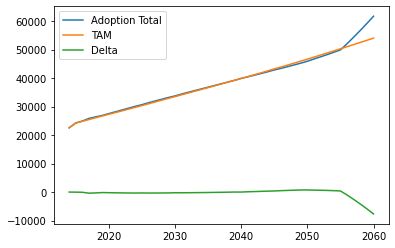

In [14]:
# Compare the an adoption to the corresponding TAM

elc.compare_adoption_to_tam(segment='PDS1').plot()   # setgment = 'reference', 'PDS1', 'PDS2' or 'PDS3'

In [ ]:
# If they don't match up, modify the conventional adoption profile, and try again.
# TODO: in the future we could provide tools to help with that, perhaps.

### Grid Emissions

In [15]:
elc.step3_calculate_emissions()

Grid Emissions factors calculated


### Save

Up until now, results have been calculated in memory only.
This step will cause following files to be updated:

 * Integrated Energy TAM
 * Grid Emissions used by all solutions
 * Final conventional adoption profile with calculated percentages

In [17]:
elc.step4_update()

Grid Emissions Data saved
PDS (Integrated) TAM saved


# Developer Section
Ignore everything from here on down... Or use this space yourself for scratch work.

In [1]:
import sys
sys.path.append('../')   # If you move this notebook to another location, change this path to point to the root directory of the solutions project
import pandas as pd
from pathlib import Path
from solution import factory
from integrations import integration_base as base
from integrations import elc_integration as elc
base.integration_clean()   # Uncomment this to remove the results of previous integration attempts
base.integration_start(True)
elc.setup(2018)   

In [2]:
elc.integrate()

Previously defined grid mix loaded for year 2018
Reference TAM sources loaded
Loading net energy deltas for all solutions; this takes some time
*** done.
integrated TAM calculated
loading previously-saved conventional adoption profile
Current conventional adoption profile loaded
Adoptions calculated
Grid Emissions factors calculated
Grid Emissions Data saved
PDS (Integrated) TAM saved


In [16]:
base.show_log()

-----------------------
elc
           historical grid mix: (20, 8): [1.00750502e+04 1.01694961e+04 1.02594500e+04 1.03454911e+04
 4.06194406e-01]
conventional adoption profile loaded: (47, 30): [2.46263872e+02 8.01643000e-03 9.97468345e+03 4.42375530e-01
 3.22997907e+03]
              current grid mix: (20, 2): [1.03454911e+04 3.93376294e-01]
                 reference tam: (47,): [22548.         24291.85200614 24971.05879537 25650.2655846
 26329.47237383]
                  net grid use: (47, 75): [-0.         -0.         -0.         -0.          0.06059409]
             grid demand delta: (47, 3): [0.         0.06059409 0.        ]
                       pds tam: (47, 3): [22548.         22548.06059409 22548.        ]
                integrated tam: (47, 3): [22548. 22548. 22548.]
ref adoption (of energy sources): (47, 19): [9974.683447   5598.241776   3904.          964.422647    905.34937675]
                  pds adoption: (47, 57): [5.59860000e+01 6.25400000e+01 9.97468345e+03 9.

In [4]:
elc.es.pds_adoption['PDS1'].columns

Index(['biogas', 'biomass', 'coal', 'concentratedsolar', 'geothermal',
       'instreamhydro', 'landfillmethane', 'large hydro', 'microwind',
       'natural gas', 'nuclear', 'offshorewind', 'oil products', 'onshorewind',
       'other biomass', 'solarpvroof', 'solarpvutil', 'wastetoenergy',
       'waveandtidal'],
      dtype='object')